# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import pkg_resources
from spacy.lang.en.stop_words import STOP_WORDS

from datetime import datetime
from collections import Counter

dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %z %Z")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
reviews = pd.read_csv("/content/drive/MyDrive/RMP/scraped_comments_with_professor.csv", parse_dates = ['date'], date_parser=dateparse).sample(n=600000, random_state=1)
# reviews[['comment_id', 'firstName', 'lastName', 'prof_class', 'comment', 'clarityRating', 'helpfulRating']].to_csv("/content/drive/MyDrive/RMP/scraped_comments_sample.csv")

In [4]:
reviews.head(5)

,professor_id,comment_id,firstName,lastName,prof_class,comment,ratingTags,date,attendanceMandatory,grade,clarityRating,difficultyRating,helpfulRating,textbookUse,thumbsDownTotal,thumbsUpTotal,wouldTakeAgain
274508,VGVhY2hlci0xMDY5NDk0,UmF0aW5nLTMwNDk4MTI3,Dianne,Kwasniewski,AH100,I am currently in Ms. Dianne Kwasniewski's AH1...,Respected--Skip class? You won't pass.--Hilarious,2018-09-12 23:18:48+00:00,NaN,Not sure yet,5,2,5,5.0,0,2,1.0
414595,VGVhY2hlci0xNDMxMzc4,UmF0aW5nLTIyMDk4ODU3,Bruce,Freeman,HUMANRELATIONS,"Pretty easy, all you really need to do is go t...",NaN,2013-09-01 18:04:12+00:00,Y,A,3,2,4,3.0,0,0,NaN
459567,VGVhY2hlci0xNjA1MDYw,UmF0aW5nLTIzMzk1OTY1,Lorne,Goldstein,CML4111A,"Fantastic class, great guy. Awesome lectures ...",NaN,2014-06-23 19:44:33+00:00,N,NaN,5,4,4,1.0,0,0,NaN
724268,VGVhY2hlci0xNTQ0NjU3,UmF0aW5nLTE4NzAzODIx,John,Trombley,CHEM1143,He's kinda new to the University. Class is not...,NaN,2011-06-06 15:13:05+00:00,NaN,NaN,4,3,4,4.0,0,0,NaN
859174,VGVhY2hlci0xMjQ2NTEz,UmF0aW5nLTI3ODQyMDIx,Lawrence,Mc Laughlin,GEOG111,He makes the class easy and the field trips ar...,Respected--Amazing lectures--Caring,2017-02-20 13:14:54+00:00,mandatory,A,5,2,5,5.0,0,8,1.0


In [5]:
reviews = reviews.loc[:, ["firstName", "lastName", "prof_class", "comment", "date", "clarityRating", "helpfulRating", "professor_id", "comment_id"]]
reviews.columns

Index(['firstName', 'lastName', 'prof_class', 'comment', 'date',
       'clarityRating', 'helpfulRating', 'professor_id', 'comment_id'],
      dtype='object')

# Rating EDA

In [6]:
reviews.dtypes

firstName                     object
lastName                      object
prof_class                    object
comment                       object
date             datetime64[ns, UTC]
clarityRating                  int64
helpfulRating                  int64
professor_id                  object
comment_id                    object
dtype: object

In [7]:
reviews.head()

,firstName,lastName,prof_class,comment,date,clarityRating,helpfulRating,professor_id,comment_id
274508,Dianne,Kwasniewski,AH100,I am currently in Ms. Dianne Kwasniewski's AH1...,2018-09-12 23:18:48+00:00,5,5,VGVhY2hlci0xMDY5NDk0,UmF0aW5nLTMwNDk4MTI3
414595,Bruce,Freeman,HUMANRELATIONS,"Pretty easy, all you really need to do is go t...",2013-09-01 18:04:12+00:00,3,4,VGVhY2hlci0xNDMxMzc4,UmF0aW5nLTIyMDk4ODU3
459567,Lorne,Goldstein,CML4111A,"Fantastic class, great guy. Awesome lectures ...",2014-06-23 19:44:33+00:00,5,4,VGVhY2hlci0xNjA1MDYw,UmF0aW5nLTIzMzk1OTY1
724268,John,Trombley,CHEM1143,He's kinda new to the University. Class is not...,2011-06-06 15:13:05+00:00,4,4,VGVhY2hlci0xNTQ0NjU3,UmF0aW5nLTE4NzAzODIx
859174,Lawrence,Mc Laughlin,GEOG111,He makes the class easy and the field trips ar...,2017-02-20 13:14:54+00:00,5,5,VGVhY2hlci0xMjQ2NTEz,UmF0aW5nLTI3ODQyMDIx


## Clarity Ratings

In [8]:
reviews.clarityRating.value_counts()

 5    270177
 4    127786
 1     73672
 3     66608
 2     61756
-1         1
Name: clarityRating, dtype: int64

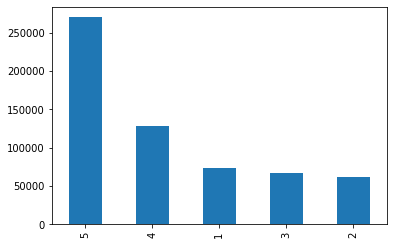

In [9]:
reviews = reviews[reviews['clarityRating'] != -1]
clarity_cnts = reviews.clarityRating.value_counts()
clarity_cnts.plot(kind='bar')

## Helpful Ratings

In [10]:
reviews.helpfulRating.value_counts()

5    307720
4    100079
1     84847
3     56727
2     50626
Name: helpfulRating, dtype: int64

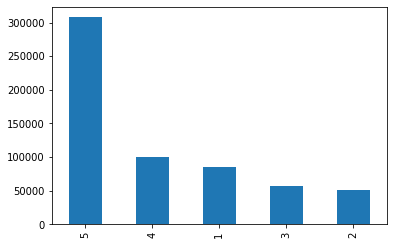

In [11]:
helpful_cnts = reviews.helpfulRating.value_counts()
helpful_cnts.plot(kind='bar')

## Asymmetric Reviews
Before 2016 helpfulRating and clarityRatings were distinct, which led to a lot of conflicting ratings. After 2016 there is only one numeric rating metric.

Here, I only considered ratings that have an absolute difference of <= 2, because it seemed that the sentiment of >2 varied greatly.

In [12]:
unsymmetric_reviews = reviews[reviews['helpfulRating'] != reviews['clarityRating']]
unsymmetric_reviews.shape

(189444, 9)

In [13]:
(abs(unsymmetric_reviews['helpfulRating'] - unsymmetric_reviews['clarityRating'])).value_counts()

1    151887
2     30569
3      5460
4      1528
dtype: int64

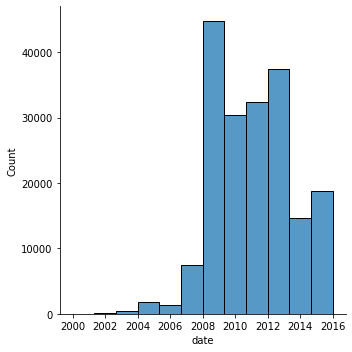

In [14]:
# Interestingly, rmp gets rid of two seperate ratings after 2016 for just one rating.
# Thus, before 2016 you can get floating point quality reviews
comment_years = unsymmetric_reviews['date'].dt.year
sns.displot(comment_years, kde=False, bins=12)

In [15]:
diff_2_reviews = reviews[abs(reviews['helpfulRating'] - reviews['clarityRating']) == 2]
diff_2_reviews.shape

(30569, 9)

In [16]:
for index, review in diff_2_reviews.head(50).iterrows():
  print()
  print(review['comment'], review['helpfulRating'], review['clarityRating'])


Dr. Kane is interesting. He loves teaching and it shows he just has trouble explaining things. He laughs at all his jokes which in humorous. He reads the test to you as a review. Great guy and will work with you. 4 2

He's great! Doesn't waste time on information that you won't need or use. His explanations are geared so you don't memorize but understand the material logically. One of the best and easiest math classes you'll ever take. Great personality! 3 5

DR. HEARON class is hard! he is tough and you need to ask previous for there flash card. He is a harder grader.  He gives you no chances.  He dose not like anything with the athletic dept. so if any of yall are athlete out there. GOODLUCK! this class is only for pre-pt and exercise science. do not messed up your lab grades. 1 3

The material was somewhat repetitive (not her fault), but she wanted students to actually learn. Did a pretty good job, always willing to answer questions in class and office hours. As long you actually d

In [17]:
reviews = reviews[abs(reviews['clarityRating'] - reviews['helpfulRating']) <= 2] # To prevent outliers
reviews.shape

(593011, 9)

## Quality Rating
The actual rating, derived from averaging the clarityRating and the helpfulRating. 

Note: After 2016, qualityRating is int because of the switch to one standard rating system.

In [18]:
reviews['qualityRating'] = (reviews['clarityRating']+reviews['helpfulRating'])/2.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
reviews['qualityRating'].value_counts()

5.0    239981
4.5     78842
4.0     70203
1.0     60558
2.0     35602
3.0     34780
3.5     26999
1.5     25518
2.5     20528
Name: qualityRating, dtype: int64

In [20]:
reviews = reviews[reviews['qualityRating'] != 3.0] # Get rid of "neutral" reviews
reviews.shape

(558231, 10)

# Comment EDA

## Null values

In [21]:
print(reviews.shape)
# drop rows with the placeholder "No Comments"
reviews = reviews[reviews["comment"] != "No Comments"]

# drop rows containing NaN comment
reviews.dropna(subset=["comment"], inplace=True)
reviews.shape

(558231, 10)


(549574, 10)

## Duplicates

In [22]:
dupes = reviews[reviews.duplicated(subset=['comment'], keep=False)]
dupes.shape

(9714, 10)

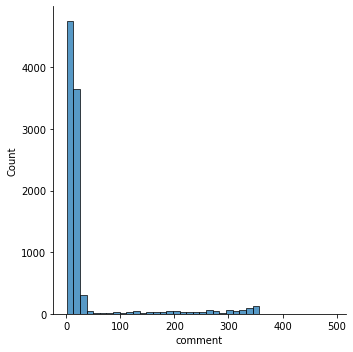

In [23]:
sns.displot(dupes['comment'].str.len(), kde=False, bins=40)

In [24]:
dupes = dupes.groupby(['comment', 'professor_id'])
dupes.first()

firstName  \
comment                                            professor_id                     
                                                   VGVhY2hlci05NzY0MDE=    Travis   
                                                   VGVhY2hlci0xMTU0NTgy  Ehikioya   
                                                   VGVhY2hlci0xMjk1OTQ0   Matthew   
                                                   VGVhY2hlci0xMjk2OTEy      John   
                                                   VGVhY2hlci0xMzA0MjE4    Pamela   
...                                                                           ...   
wow                                                VGVhY2hlci0xMjUwNDI4  Jerry L.   
                                                   VGVhY2hlci0xMzM1Mjc5     Scott   
you have to do 10 one page movie assignments an... VGVhY2hlci0xMjUzMDMz     Frank   
you'll learn a lot!                                VGVhY2hlci05Nzk2MDY=   Barbara   
                                                   VGVhY2hlci0xMjgxNTkw      Noel   

                                                                               lastName  \
comment                                            professor_id                           
                                                   VGVhY2hlci05NzY0MDE=         Silvers   
                                                   VGVhY2hlci0xMTU0NTgy         Agboaye   
                                                   VGVhY2hlci0xMjk1OTQ0         Ianucci   
                                                   VGVhY2hlci0xMjk2OTEy         Persico   
                                                   VGVhY2hlci0xMzA0MjE4  Gordon-Johnson   
...                                                                                 ...   
wow                                                VGVhY2hlci0xMjUwNDI4          Rouser   
                                                   VGVhY2hlci0xMzM1Mjc5       King-Owen   
you have to do 10 one page movie assignments an... VGVhY2hlci0xMjUzMDMz        Espinoza   
you'll learn a lot!                                VGVhY2hlci05Nzk2MDY=         Bartkus   
                                                   VGVhY2hlci0xMjgxNTkw         Plourde   

                                                                        prof_class  \
comment                                            professor_id                      
                                                   VGVhY2hlci05NzY0MDE=  MUSIC030A   
                                                   VGVhY2hlci0xMTU0NTgy   GOVT1302   
                                                   VGVhY2hlci0xMjk1OTQ0     SSC101   
                                                   VGVhY2hlci0xMjk2OTEy   MANAG310   
                                                   VGVhY2hlci0xMzA0MjE4     ECE201   
...                                                                            ...   
wow                                                VGVhY2hlci0xMjUwNDI4    YAS1231   
                                                   VGVhY2hlci0xMzM1Mjc5   PHILO131   
you have to do 10 one page movie assignments an... VGVhY2hlci0xMjUzMDMz   PSYCH001   
you'll learn a lot!                                VGVhY2hlci05Nzk2MDY=    MGMT485   
                                                   VGVhY2hlci0xMjgxNTkw     ENG131   

                                                                                             date  \
comment                                            professor_id                                     
                                                   VGVhY2hlci05NzY0MDE= 2022-05-14 04:54:30+00:00   
                                                   VGVhY2hlci0xMTU0NTgy 2022-05-19 03:23:55+00:00   
                                                   VGVhY2hlci0xMjk1OTQ0 2022-05-04 20:33:00+00:00   
                                                   VGVhY2hlci0xMjk2OTEy 2022-07-20 19:03:06+00:00   
                                                   VGVhY2

In [25]:
reviews.drop_duplicates(subset=['comment'], keep='first', inplace=True)
reviews.shape

(541988, 10)

## Comment Lengths

In [26]:
comment_lengths = reviews['comment'].astype(str).str.len() # .astype(str) needed for some reason to actually get int values
comment_length_cnts = comment_lengths.value_counts()
comment_length_cnts

350    25707
349    13855
348    10764
347     9358
346     8060
       ...  
448        1
468        1
723        1
429        1
766        1
Name: comment, Length: 536, dtype: int64

In [27]:
comment_lengths.describe()

count    541988.000000
mean        229.041494
std         102.635086
min           1.000000
25%         147.000000
50%         244.000000
75%         330.000000
max        1678.000000
Name: comment, dtype: float64

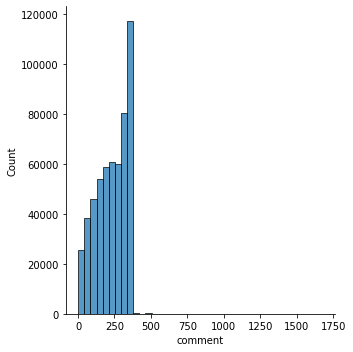

In [28]:
sns.displot(comment_lengths, kde=False, bins=40)

In [29]:
very_long_reviews = reviews[reviews['comment'].str.len() >= 500]
very_long_reviews.shape # Only 35 from the sample of 600,000; debateable whether they should be removed or not, considered outliers?

(55, 10)

In [30]:
for comment in very_long_reviews['comment']:
  print(comment)
  print()

It's not the easiest class, but I loved it! Tests are mostly multiple choice with some blue book essays, take A LOT of notes and study and you'll be fine. She is fair, but you definitely want to be on her good side- easy to do, just pay attention, be engaged and work hard. She knows her subject VERY well. She has a no-nonsense attitude which can come off as curt, but shes actually really nice if you are. Think about a question before asking, she doesn't like to be interrupted for trivial things.

theShe is very sweet and caring and she knows her stuff. However does not know how to teach it. Her lectures are not clear and sometimes she has to stop and think if she is correct. I know everyone is not perfect but you think with her experience she would be a little better. I didn't pass this class for two reasons one being that I didn't study like i should have and two things were not always clear. Majority of the people in the class thought the same thing. There were some really good stude

In [31]:
short_reviews = reviews[reviews['comment'].str.len() < 20]
short_reviews.shape

(7195, 10)

In [32]:
for comment in short_reviews['comment'].head(50):
  print(comment)
  print()

AWESOME

amazing teacher

George was the man!

Super easy teacher.

She was great!

She really cares.

Great teacher!

great

SUPER EASY

good teacher

Good teacher

hot

Nice professor

I liked this class

Amazing Professor!

Great teacher ....

Really great guy!

energetic

Very nice teacher

Great professor! 

awesome prof!

the very best!

He is cool.

She is rude.

Great Class!

Great professor.

Amazing professor!

AMAZING!

Excellent teacher

the worst

he is great teacher

nice and helpful

Great

I love RIT

good prof

.

very sweet!!

A great professor.

Great professor

great book!

very good

i love her

fun and easy.

great teacher

She's awesome.

Awesome!

eh

Hot professor

:(

Awesome prof!



In [33]:
# reviews = reviews[reviews['comment'].str.len() > 20]

## Professor Ids

In [34]:
professor_ids = reviews['professor_id']
professor_cnts = professor_ids.value_counts()
professor_cnts.describe()

count    95537.000000
mean         5.673069
std          7.522613
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        336.000000
Name: professor_id, dtype: float64

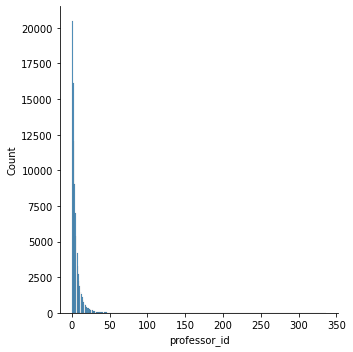

In [35]:
sns.displot(professor_cnts, kde=False, bins=400)

In [36]:
# professors_5_reviews = reviews[professor_cnts[reviews['professor_id']] >= 5]
prof_id_cnts = reviews.groupby('professor_id')['professor_id'].transform('size')
# professors_filtered = reviews[prof_id_cnts <= 50]
professors_filtered = reviews[(prof_id_cnts >= 3) & (prof_id_cnts <= 50)]

# Maybe we might need to filter <= 50 reviews...

In [37]:
professors_filtered['professor_id'].describe()

count                   465543
unique                   58612
top       VGVhY2hlci05OTkxMTU=
freq                        50
Name: professor_id, dtype: object

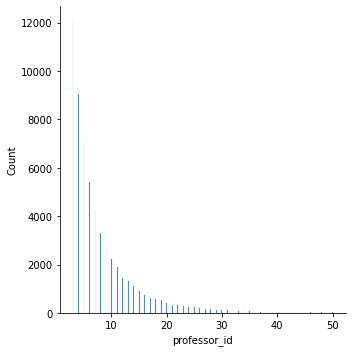

In [38]:
sns.displot(professors_filtered['professor_id'].value_counts(), kde=False, bins=400)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


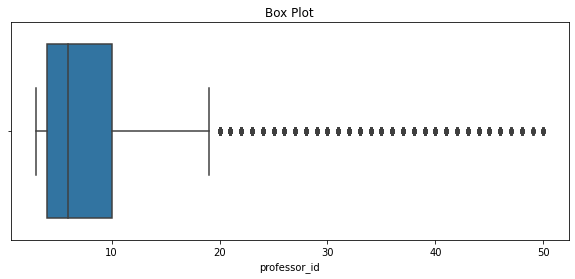

In [39]:
plt.figure(figsize=(10, 4))
plt.title("Box Plot")
sns.boxplot(professors_filtered['professor_id'].value_counts())
plt.show()

In [40]:
professors_filtered['sentiment'] = professors_filtered['qualityRating'] > 3.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
professors_filtered['professor_id'].value_counts()

VGVhY2hlci05OTkxMTU=    50
VGVhY2hlci0xMDM2NzE1    50
VGVhY2hlci0xNTA4ODgw    50
VGVhY2hlci0xMjE5NjM1    50
VGVhY2hlci0xNDkzOTM5    50
                        ..
VGVhY2hlci0xMjM2NDY1     3
VGVhY2hlci0xMjM1OTc1     3
VGVhY2hlci0xNDY1MDg0     3
VGVhY2hlci0xNDg5MDgx     3
VGVhY2hlci05NTI3Nzc=     3
Name: professor_id, Length: 58612, dtype: int64

In [42]:
# test_group = professors_filtered.groupby(['professor_id']).apply(pd.DataFrame.sample, n=5, replace=False)
professors_pruned = professors_filtered.sample(frac = 1.0).groupby('professor_id').head(7)
professors_pruned.shape

(315464, 11)

In [43]:
professors_pruned['professor_id'].value_counts()

VGVhY2hlci0xMjI0MjYz    7
VGVhY2hlci0xMjMyMzAx    7
VGVhY2hlci0xNTE1MzQ0    7
VGVhY2hlci0xMDUyNTcz    7
VGVhY2hlci0xMjMxNDc5    7
                       ..
VGVhY2hlci05NzY4NTI=    3
VGVhY2hlci05NzU5NTU=    3
VGVhY2hlci0xMzExMjk4    3
VGVhY2hlci0xNDYzNDk3    3
VGVhY2hlci0xNTM2MDEz    3
Name: professor_id, Length: 58612, dtype: int64

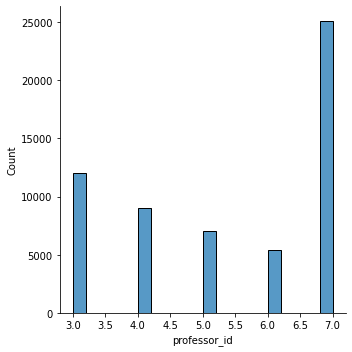

In [44]:
sns.displot(professors_pruned['professor_id'].value_counts(), kde=False, bins=20)

In [45]:
sentiment_cnts = professors_pruned.sentiment.value_counts()
sentiment_cnts

True     232255
False     83209
Name: sentiment, dtype: int64

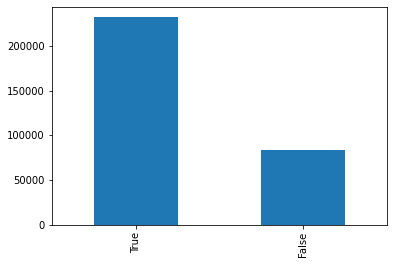

In [46]:
sentiment_cnts.plot(kind='bar')

In [47]:
sentiment_cnts[True]/sum(sentiment_cnts)

0.7362329774554307

In [48]:
professors_pruned.to_csv('/content/drive/MyDrive/RMP/reviews_filtered.csv')